# Прогнозирование оттока клиентов 

Менеджмент оператора связи хочет научиться прогнозировать отток клиентов, чтобы бороться с ним с помощью индивидуальных предложений: специальных промокодов и льготных условий.

Оператор предоставляет два основных типа услуг: стационарную телефонную связь и интернет, а также большое число дополнительных сервисов. 

Данные содержатся в четырех разных файлах, которые мы объединим в один.

### План решения задачи

##### Часть 1. Подготовка данных:
* [1. Загрузка и изучение данных](#1-bullet)
* [2. Изучение выбросов](#2-bullet)
* [3. Заполнение пропусков](#3-bullet)
* [4. Финальная обработка](#4-bullet)

##### Часть 2. Обучение моделей:
* [1. Построение первых моделей](#5-bullet)
* [2. Удаляем "лишние" признаки](#6-bullet)
* [3. Kmean](#7-bullet)
* [4. Выводы](#8-bullet)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score

# Должно помочь с проблемой несбалансированных классов
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

# Отключаем предупреждения
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Снимаем ограничения на просмотр таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Для компактного и красивого отображения оутпутов
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# настройки графиков

sns.set_context(
    "paper", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (12, 6), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6

# Часть 1. Подготовка данных
### 1.1 Загрузка и изучение данных <a id='1-bullet'></a>

In [3]:
df_contract = pd.read_csv('contract.csv')
df_personal = pd.read_csv('personal.csv')
df_internet = pd.read_csv('internet.csv')
df_phone = pd.read_csv('phone.csv')

In [4]:
# Функция для отображения названия датасета

def test(data):
    name = [x for x in globals() if globals()[x] is data][0]
    print(name)

In [5]:
# Посмотрим первые строки таблиц

for df in (df_contract, df_personal, df_internet, df_phone):
    test(df)
    df.head()
    print('')

df_contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



df_personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



df_internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



df_phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [6]:
# Изучим общую информацию

for df in (df_contract, df_personal, df_internet, df_phone):
    test(df)
    df.info()
    print('')

df_contract
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

df_personal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043

In [7]:
# Изучим общие статистические данные

for df in (df_contract, df_personal, df_internet, df_phone):
    test(df)
    df.describe()

df_contract


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


df_personal


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


df_internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5614-DNZCE,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


df_phone


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1618-CFHME,No
freq,1,3390


In [8]:
# Проверим на дубликаты

for df in (df_contract, df_personal, df_internet, df_phone):
    test(df)
    df.duplicated().sum()

df_contract


0

df_personal


0

df_internet


0

df_phone


0

In [9]:
# Посмотрим сколько в датасете действующих клиентов в процентах

df_contract.query('EndDate == "No"')['customerID'].count()/df_contract.shape[0]*100

73.4630129206304

### Предварительные выводы
Пропуски пока отсутствуют, как и дубликаты, но после предобработки и объединения должны появится - таблицы с разным количеством строк. Классы не сбалансированы: 81% действующих клиентов - это необходимо учесть в дальнейшем.

Необходимо заменить типы данных в столбце *contract*:
- 'BeginDate' и 'EndDate' в datetime
- 'type' и 'payment_method' в category
- 'total_charges' во float

Также выделим таргет: ушел клиент или нет, и объеденим все таблицы в одну

### 1.2 Предобработка данных <a id='2-bullet'></a>

#### Таблица 'contract'

In [10]:
# datetime

df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], errors='coerce')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')

# category

df_contract.loc[:, ['Type', 'PaymentMethod']] = df_contract[['Type', 'PaymentMethod']].astype('category')

# float

df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'] , errors = 'coerce')
df_contract['MonthlyCharges'] = pd.to_numeric(df_contract['MonthlyCharges'] , errors = 'coerce')

In [11]:
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: category(2), datetime64[ns](2), float64(2), object(2)
memory usage: 344.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Красиво, но появились пропуски в 'TotalCharges'. По всей видимости это самые новые клиенты, которые еще не успели внести оплату

In [12]:
df_contract.query('TotalCharges != TotalCharges')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Информация о договорах актуальна на 1 февраля 2020, так что наша догадка подтверждается. Заменим NaN на 0.

In [13]:
df_contract['TotalCharges'].fillna(0, inplace=True)
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: category(2), datetime64[ns](2), float64(2), object(2)
memory usage: 344.3+ KB


Будет полезно добавить новый признак - "Срок жизни клиента в днях": он будет более информативен, чем голые даты 

In [14]:
# Для расчетов добавим новый столбец и конвертируем в datetime

df_contract['EndDate_new'] = df_contract['EndDate'].fillna('2020-02-01 00:00:00')
df_contract['EndDate_new'] = pd.to_datetime(df_contract['EndDate_new'])

# Создаем новый признак

df_contract['lifetime'] = (df_contract['EndDate_new'] - df_contract['BeginDate']).dt.days.astype('int')

# Удалим ненужный столбец сразу, чтобы не забыть

df_contract.drop(columns=['EndDate_new'], inplace=True)

df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,lifetime
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61


Создаем целевой признак

In [15]:
df_contract['Churn'] = (~df_contract['EndDate'].isna()).astype('int')
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,lifetime,Churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,31,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,1036,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,1371,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,1


Объеденим все таблицы в один датафрейм

In [16]:
# у нас много датафреймов, так что имеет смысл применить функцию reduce()
from functools import reduce

dfs = [df_contract, df_personal, df_internet, df_phone]

# мерджим каждую таблицу последовательно

df_merged = reduce(lambda left, right: pd.merge(left, right, on='customerID', how='left'), dfs)

In [17]:
# customerID следует удалить, так как этот столбец не несет смысловой нагрузки

df_merged = df_merged.drop(['customerID'] , axis=1)

df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1869 non-null   datetime64[ns]
 2   Type              7043 non-null   category      
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   category      
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   lifetime          7043 non-null   int64         
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,lifetime,Churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,31,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,1036,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,1371,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Мы закончили предобработку данных и в конце концов получили красивый объединенный датасет, который будем исследовать

### 1.3 Исследовательский анализ данных <a id='3-bullet'></a>

#### Количественные признаки

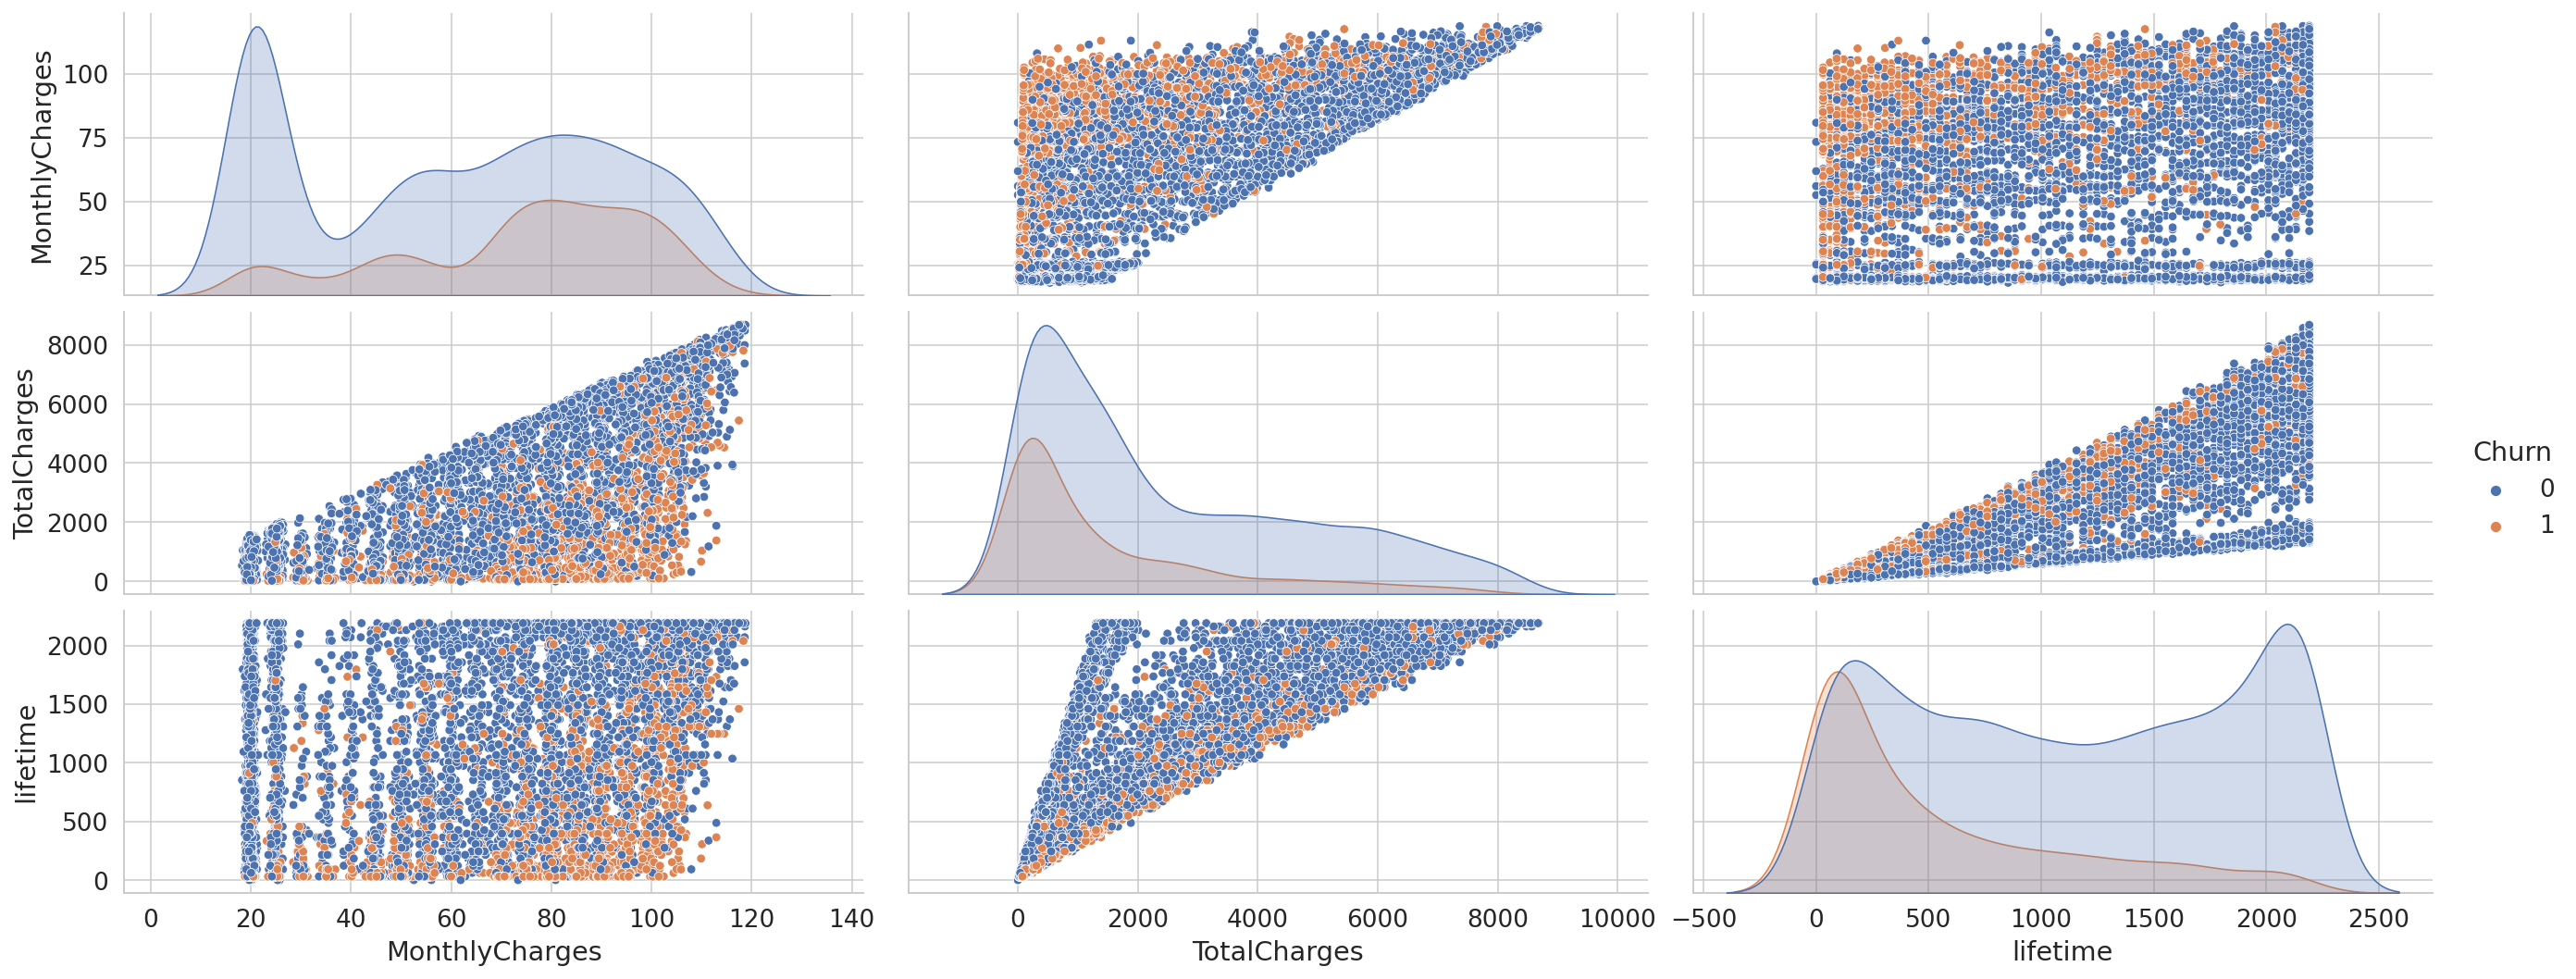

In [18]:
sns.pairplot(df_merged[['MonthlyCharges', 'TotalCharges', 'lifetime', 'Churn']], height=2.5, aspect=2.5, hue='Churn')

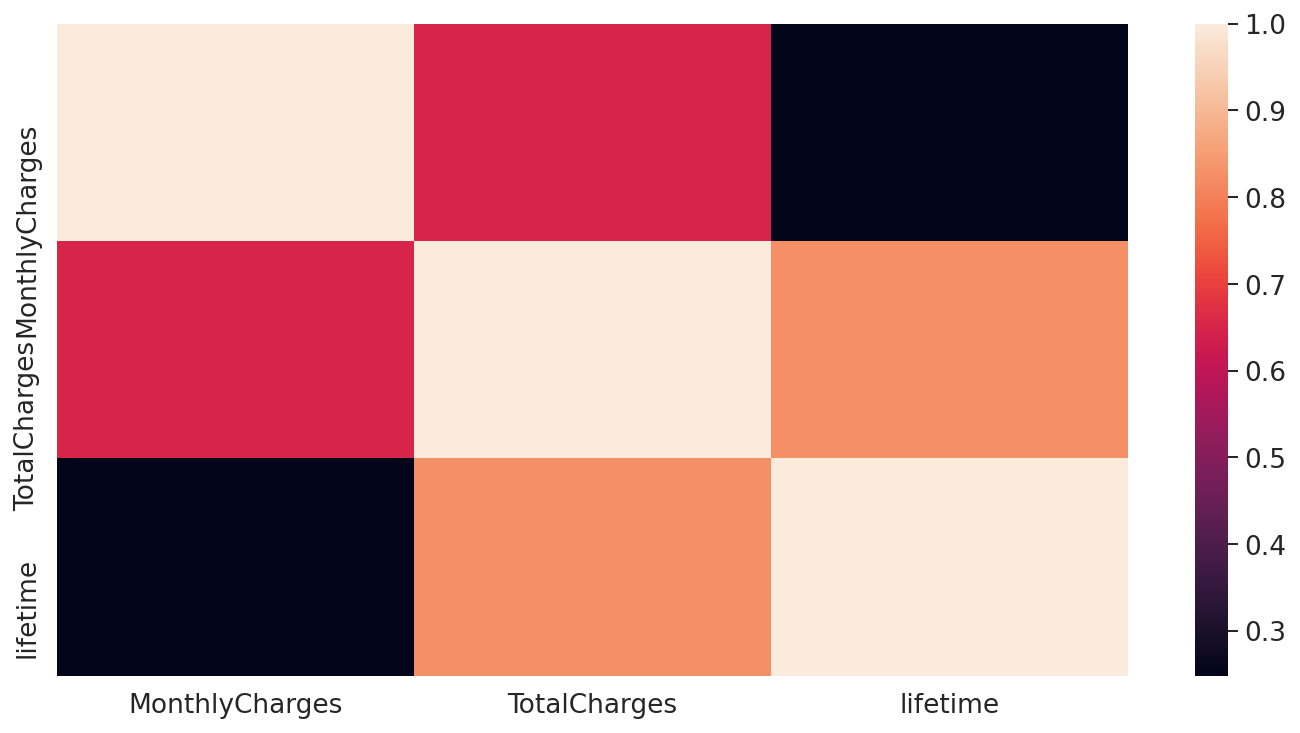

In [19]:
corr_matrix = df_merged[['MonthlyCharges', 'TotalCharges', 'lifetime']].corr()
sns.heatmap(corr_matrix)

Можно отметить, что ушедшие клиенты склонны переплачивать по сравнению с теми кто продолжает сотрудничать. Как правило решение об отказе от услуг происходит в первые месяцы после подключения услуг. Таким образом, стоит усилить клиентскую поддержку: брать обратную связь в первые недели после подключения и помогать избегать переплаты, чтобы получать выгоду в долгосрочном интервале, а не только в краткосрочном.

Договор можно продлевать каждый месяц либо сразу заключить на 1-2 года. По всей видимости, второй вариант оказывается гораздо выгоднее для клиента. Возможно, продавцам стоит ориентировать клиента сразу на долгосрочное сотрудничество, ярко расписывая все преимущества.  

Что касается признаков, то стоит отметить зависимость 'TotalCharges' и 'lifetime'. Это логично, ведь чем дольше клиент с нами, тем больше он в итоге заплатит. Удалим этот признак во время теста моделей и оценим изменения.

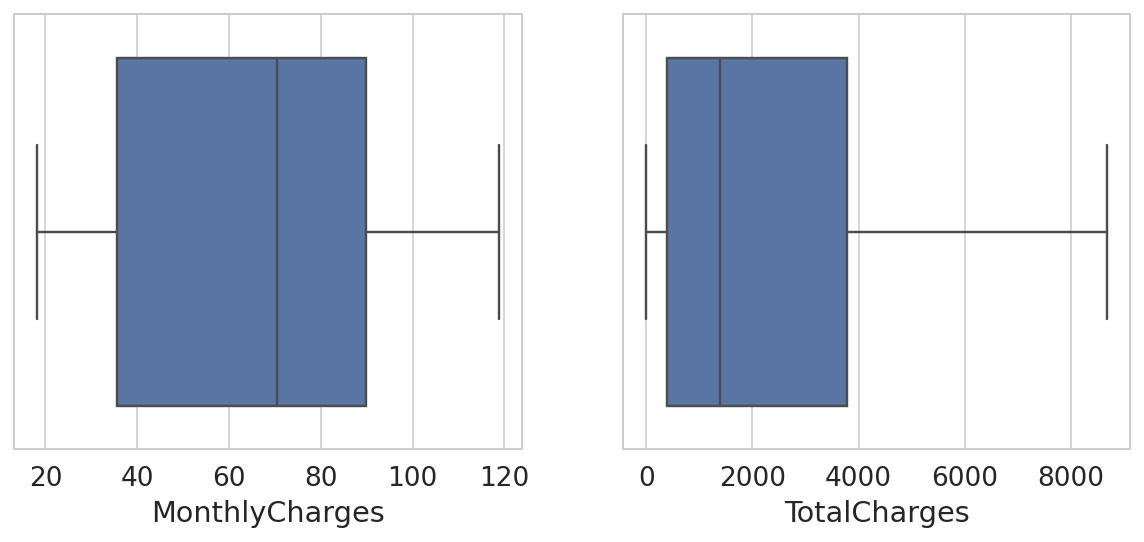

In [20]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
sns.boxplot(x="MonthlyCharges", hue='Churn', data=df_merged, ax=axes[0])
sns.boxplot(x="TotalCharges", hue='Churn', data=df_merged, ax=axes[1])

Выбросов, с которыми необходимо бороться, на графиках не обнаружено. 

#### Категориальные признаки

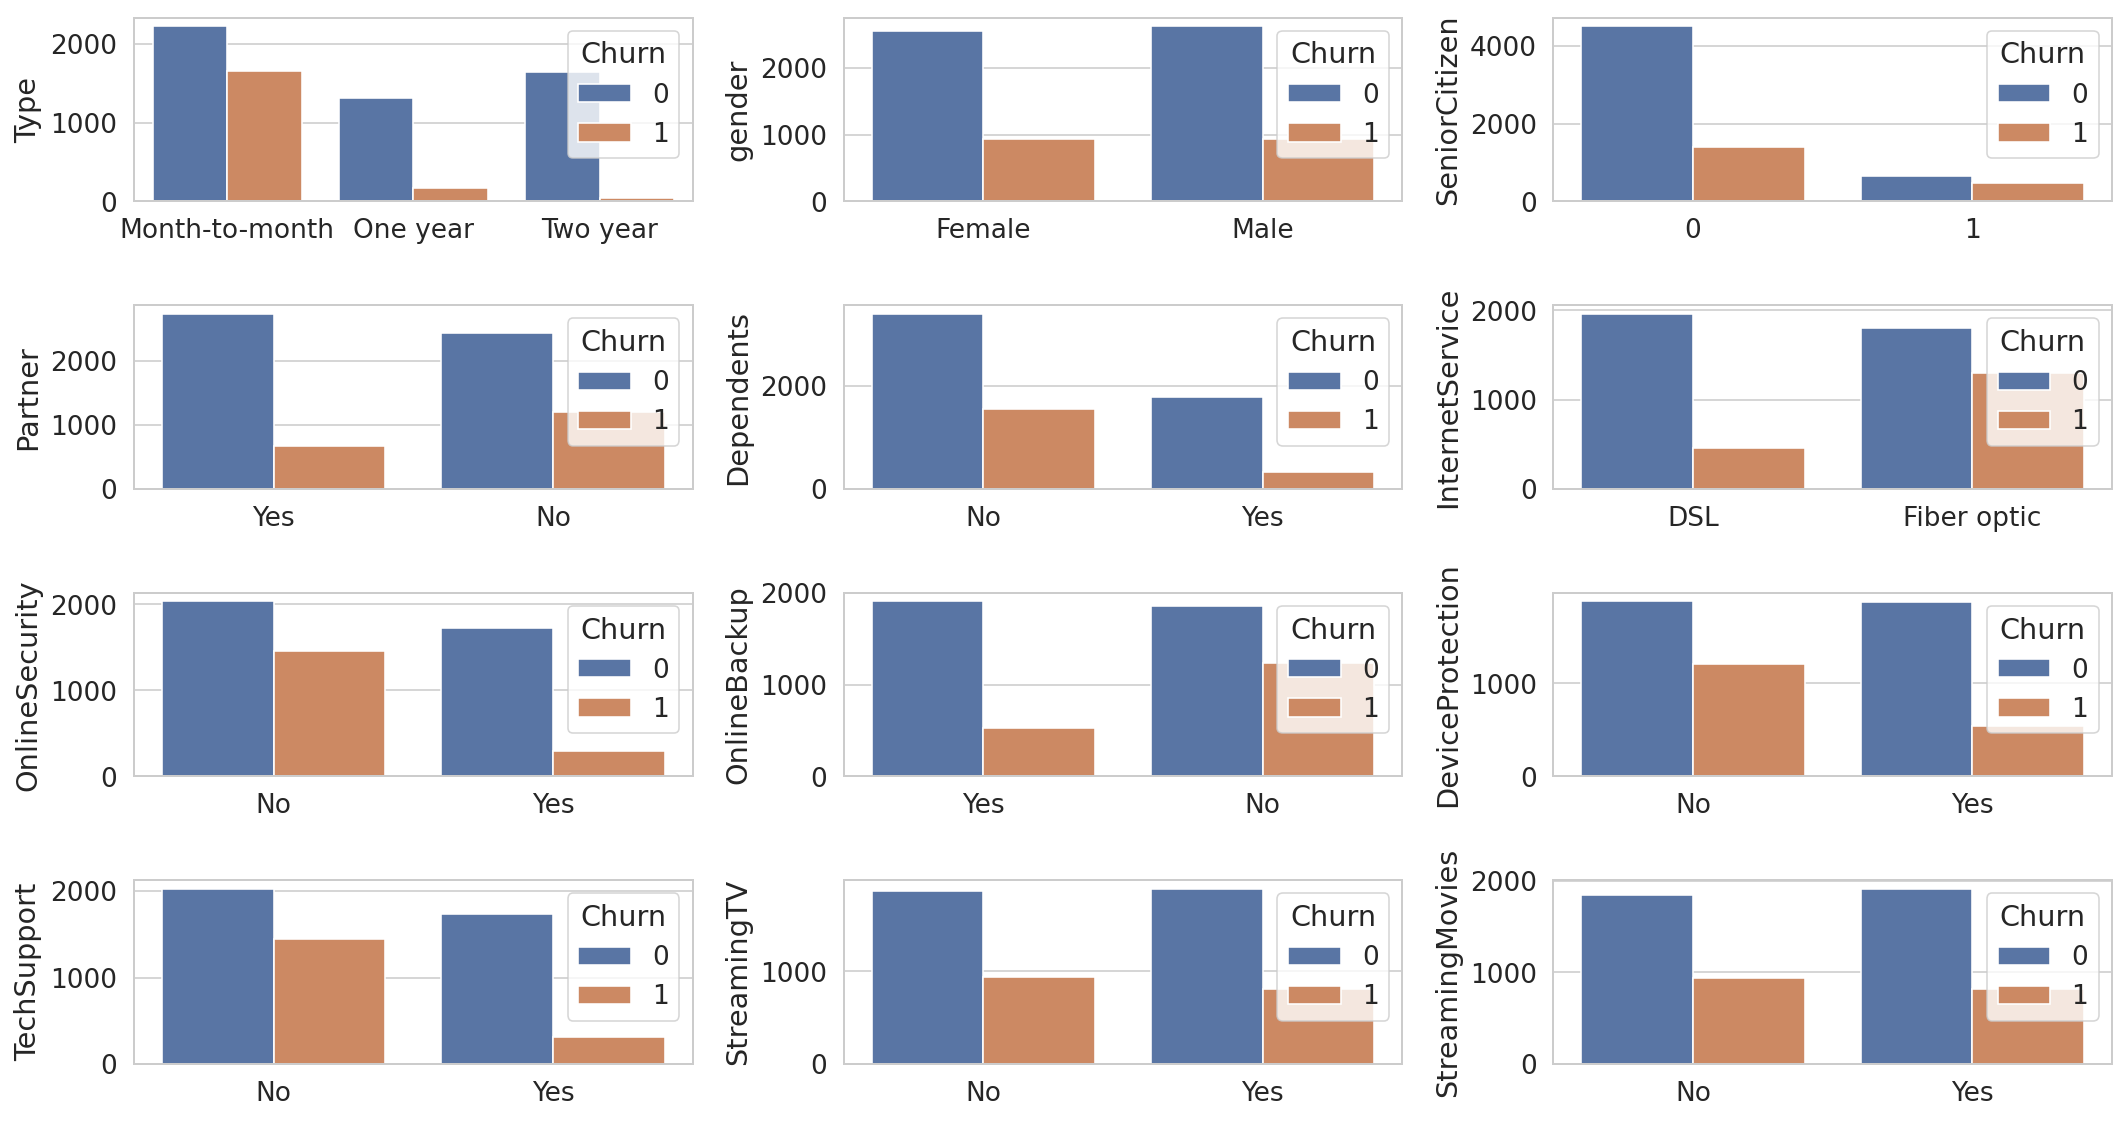

In [21]:
categorical = ['Type', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 8))
for idx, feat in enumerate(categorical):
    ax = axes[int(idx / 3), idx % 3]
    sns.countplot(x=feat, hue='Churn', data=df_merged, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout();

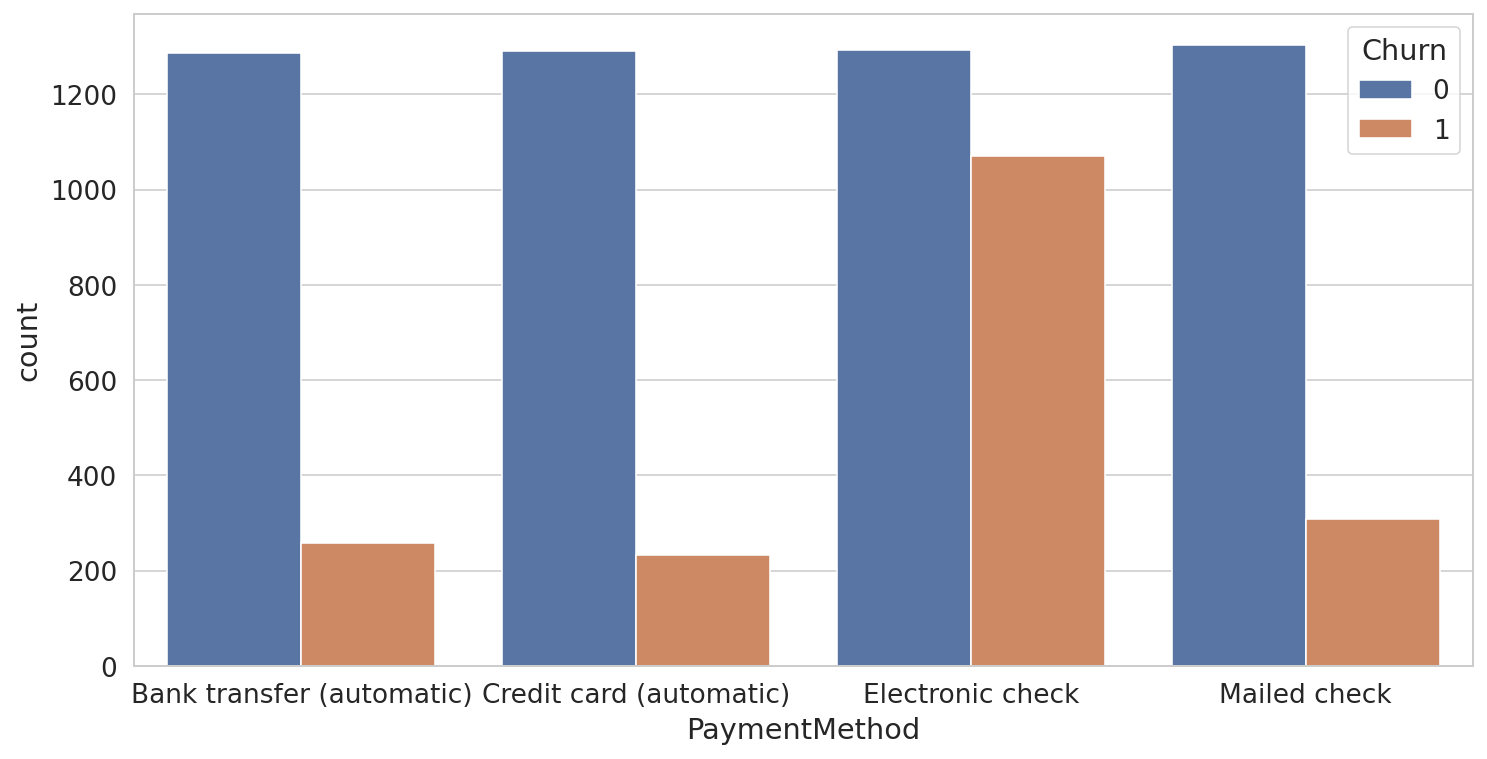

In [22]:
sns.countplot(x='PaymentMethod', hue='Churn', data=df_merged)

От услуг отказываются главным образом те, кто оформляет краткосрочные договоры, и соответственно самостоятельно оплачивает каждый чек (без автоматического списания).

Уходит ощутимо больше клиентов, которые подключили интернет через оптоволоконный кабель (Fiber optic) - по всей видимости этот вид подключения не такой быстрый как думают в компании.

В целом, наличие дополнительных услуг свидетельствует о желании продолжить сотрудничество

Наличие партнера и иждивенцев способствует долгосрочному сотрудничеству

### 1.4 Финальная обработка <a id='4-bullet'></a>

Избавимся от ненужных столбцов, применим OneHotEncoding для категориальных признаков, заменим 'Yes' и 'No' на понятные для машины значения и разделим датасет на обучающую и тестовую выборки

In [23]:
# Создадим функцию для замены yes/no

def preprocessing(df, col):
    df[col] = pd.Series(np.where(df[col].values == 'Yes', 1, 0),
          df.index)

In [24]:
# Формула для отрисовки важных фичей

def feature_imp(model_name):
    
    model = model_name
    model.fit(df_merged_test.drop('Churn', axis=1), df_merged_test['Churn'])
    sns.barplot(y=model.feature_importances_, x=df_merged_test.drop('Churn', axis=1).columns)
    plt.xticks(rotation=80)

In [25]:
# Для начала удалим столбцы, которые нам не потребуются

df_merged.drop(columns=['BeginDate', 'EndDate'], inplace=True)

# Пропуск в услугах подразумевает то, что клиент ею не пользовался

needs_fill = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
          'DeviceProtection', 'TechSupport', 'StreamingTV',
          'StreamingMovies', 'MultipleLines']

for col in needs_fill:
  df_merged[col].fillna(0, inplace=True)


df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   object  
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   TotalCharges      7043 non-null   float64 
 5   lifetime          7043 non-null   int64   
 6   Churn             7043 non-null   int64   
 7   gender            7043 non-null   object  
 8   SeniorCitizen     7043 non-null   int64   
 9   Partner           7043 non-null   object  
 10  Dependents        7043 non-null   object  
 11  InternetService   7043 non-null   object  
 12  OnlineSecurity    7043 non-null   object  
 13  OnlineBackup      7043 non-null   object  
 14  DeviceProtection  7043 non-null   object  
 15  TechSupport       7043 non-null   object  
 16  StreamingTV       7043 n

In [26]:
df_merged.PaperlessBilling.unique()

array(['Yes', 'No'], dtype=object)

In [27]:
# Применим OneHotEncoding к категориальным признакам  
# и удалим изначальные столбцы
df_merged = pd.get_dummies(df_merged, columns=['Type', 'PaymentMethod', 
                                                       'InternetService', 'gender'], 
                           drop_first=True)

# Приведем к понятному для машины виду категориальные столбцы, но сделаем это в новом датасете

df_merged_test = df_merged.copy()

# Применим нашу формулу к стобцам с типа yes/no 

for col in ('PaperlessBilling', 'Partner', 'Dependents', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies',
            'MultipleLines'):
    preprocessing(df_merged_test, col)

df_merged_test.head(3)

,PaperlessBilling,MonthlyCharges,TotalCharges,lifetime,Churn,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,gender_Male
0,1,29.85,29.85,31,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,56.95,1889.50,1036,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1
2,1,53.85,108.15,61,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1


Посмотрим feature_importances_ наших моделей

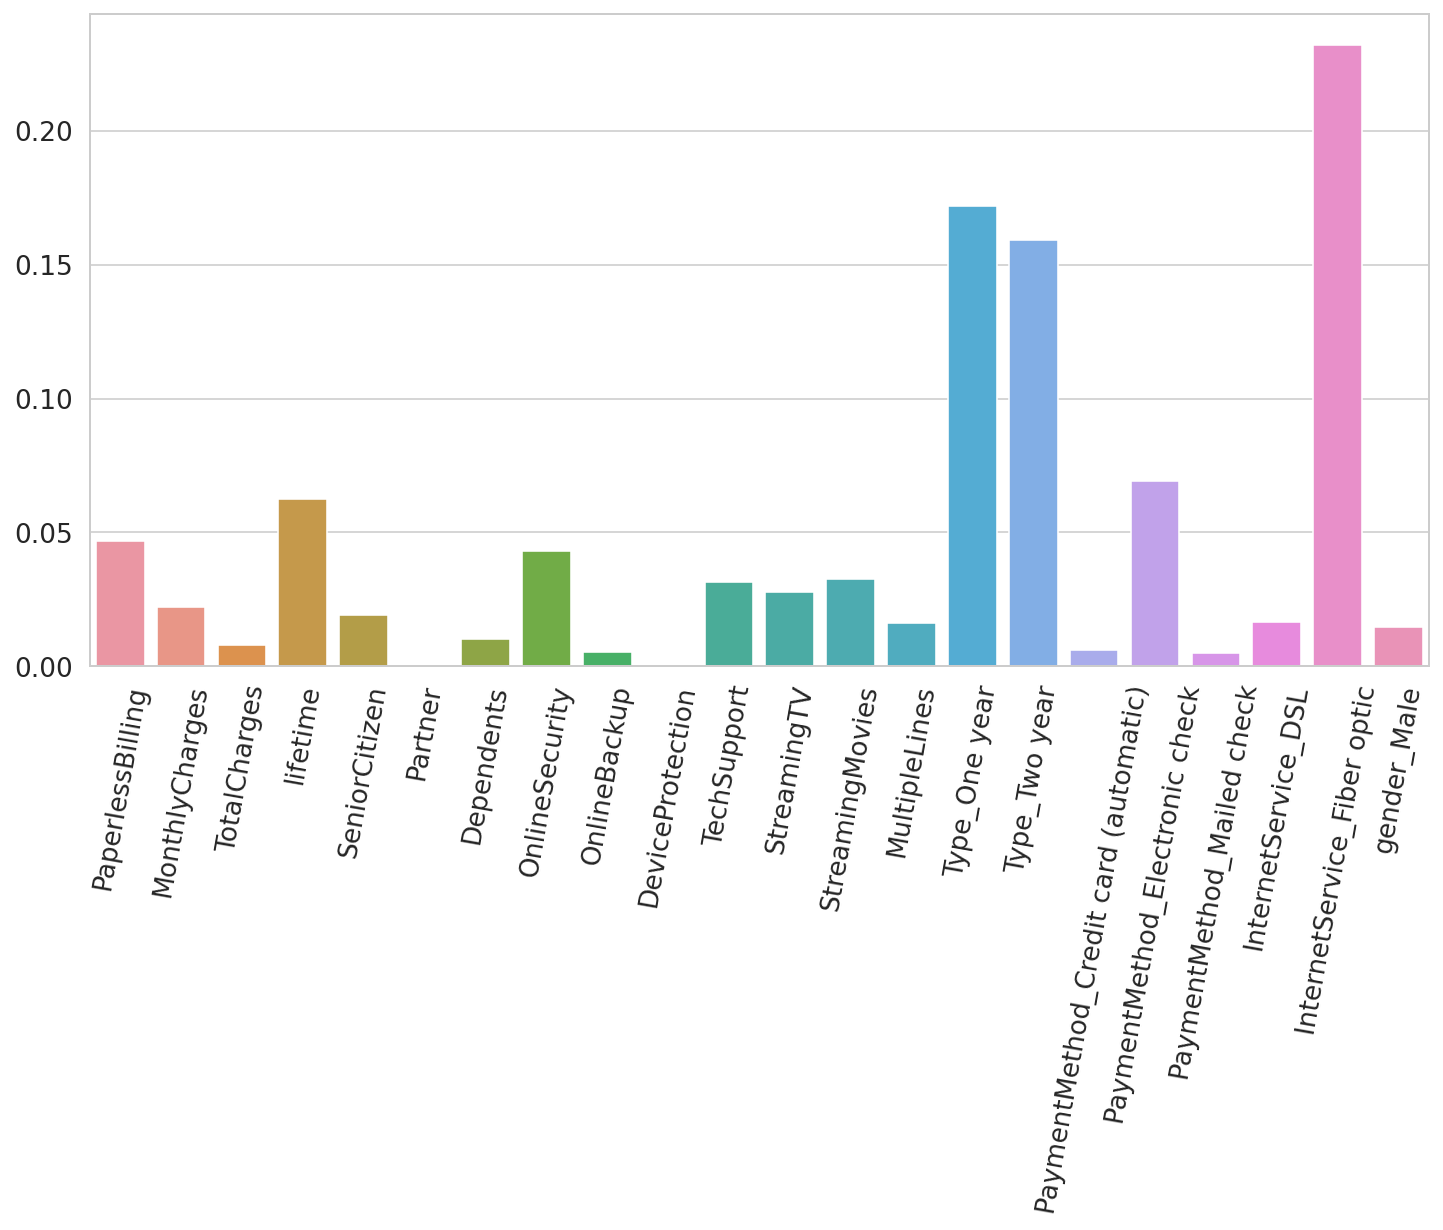

In [28]:
feature_imp(XGBClassifier())

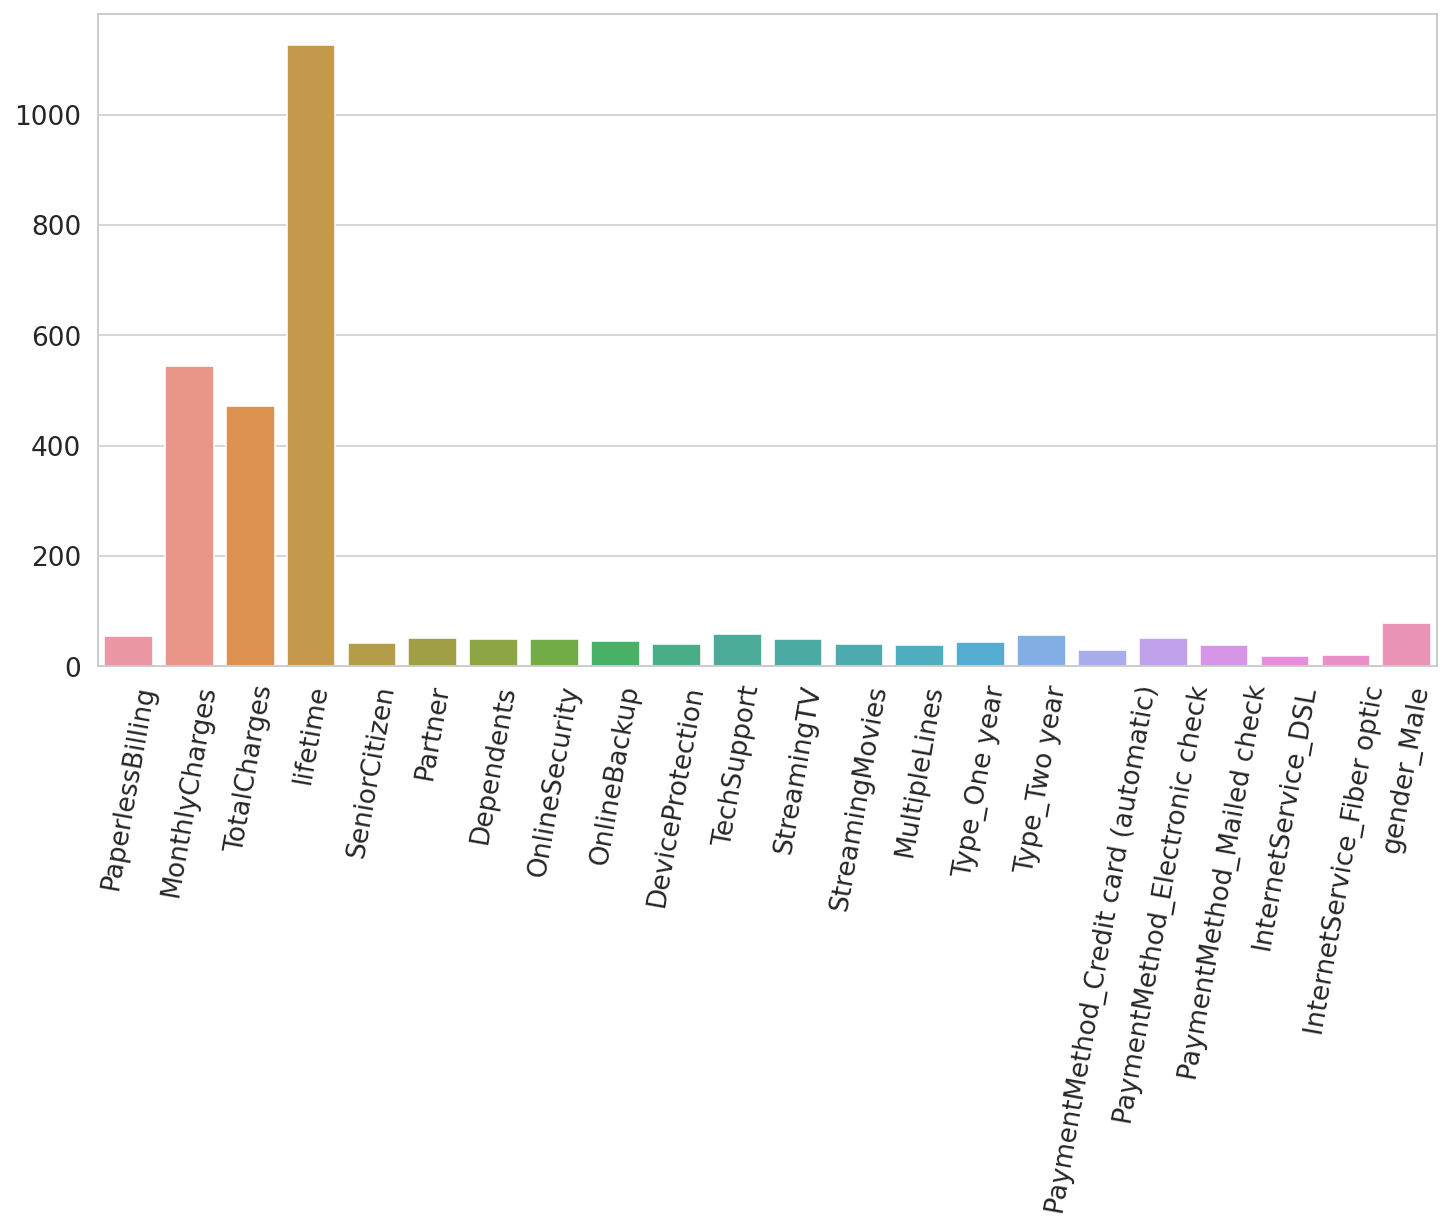

In [29]:
feature_imp(LGBMClassifier())

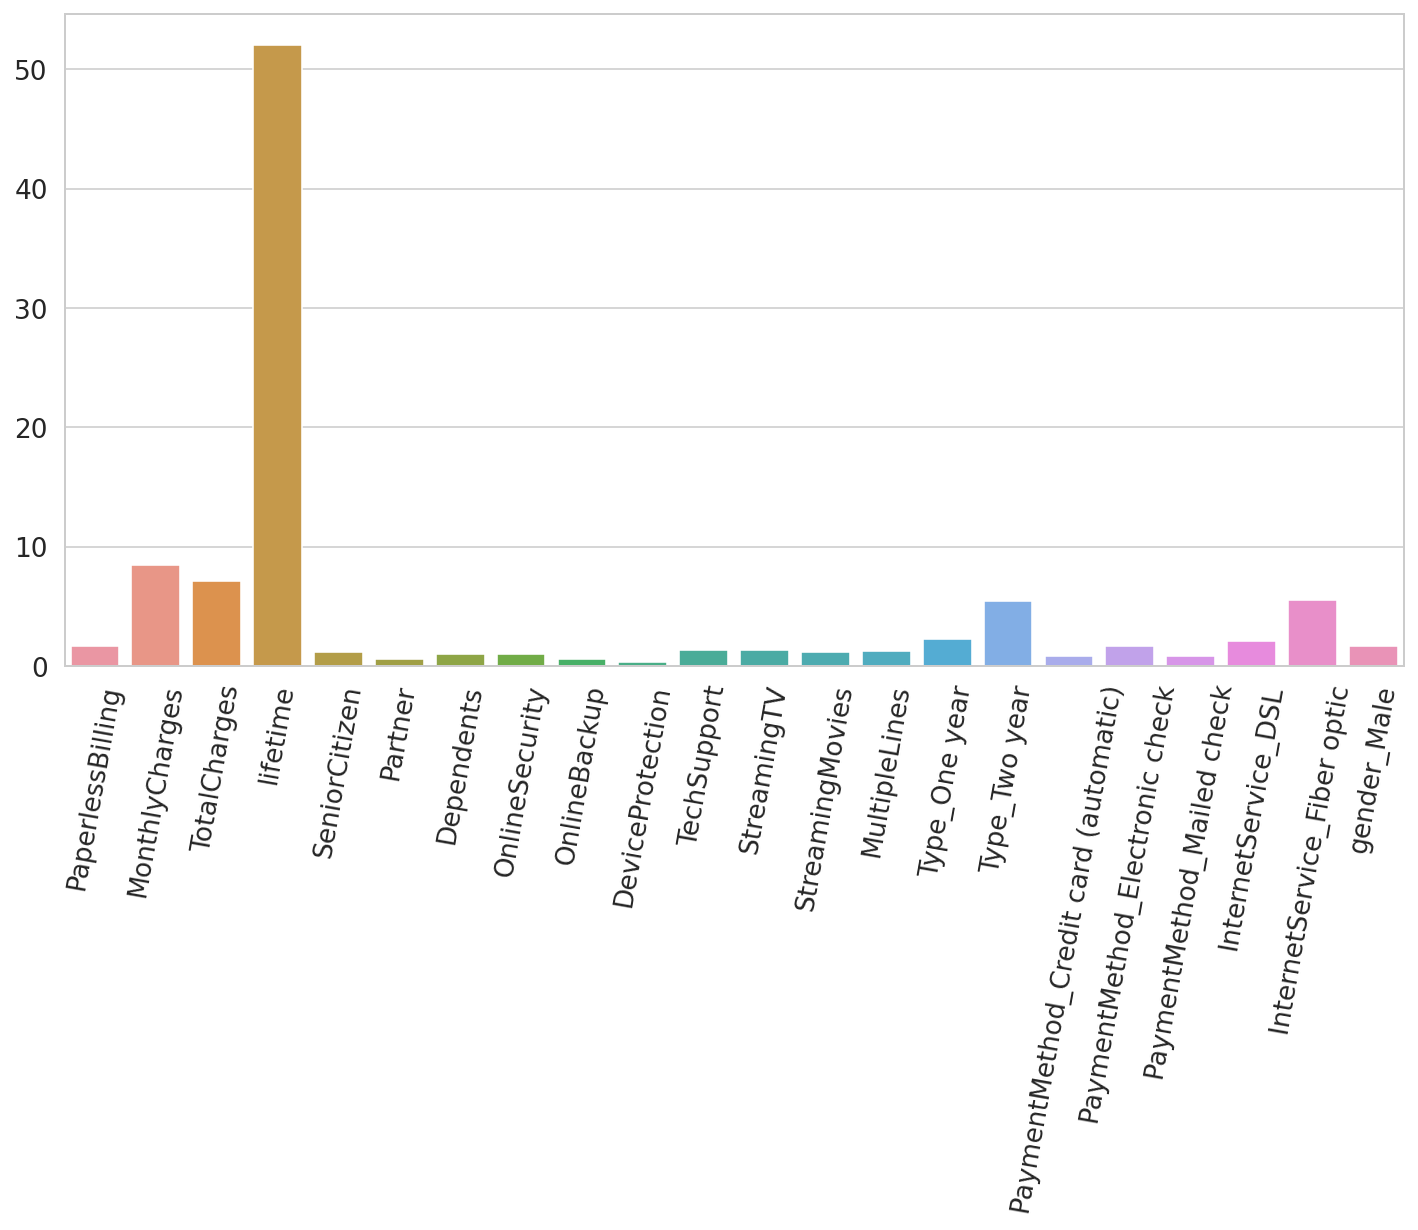

In [30]:
feature_imp(CatBoostClassifier(logging_level='Silent'))

Столбцы с допуслугами (как мы и предполагали) не помогают моделям работать точнее - предварительные тесты моделей показали, что если их удалить, то качество станет ощутимо лучше. Причем, Catboost научится предсказывать точнее если эти фичи "занулить", а не просто удалить. В то время как работа других моделей существенно не изменится.

In [31]:
cat_feature = ['PaperlessBilling', 'Partner', 'Dependents', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies',
                'MultipleLines']

for col in ('PaperlessBilling', 'Partner', 'Dependents', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies',
            'MultipleLines'):
    df_merged[col] = pd.Series(np.where(df_merged[col].values == 'nonsense', 1, 0),
          df_merged.index)

In [32]:
# выделяем target и разделяем датасет
# проблему дисбаланса будем решать дальше

X = df_merged.drop(['Churn'], axis=1)
y = df_merged['Churn']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 22), (1761, 22), (5282,), (1761,))

# Часть 2. Обучение моделей
### 2.1 Построение первых моделей  <a id='5-bullet'></a>

Обучать будем четыре модели: одну линейную - LogisticRegression (вдруг деревья плохо подходят к этой задаче) и три "деревянных" - XGBClassifier, LGBMClassifier, CatBoostClassifier.

Параметры будем хранить в словарях, а процесс перебора будем происходить через GridSearchCV.



In [33]:
# Немного автоматизируем GridSearch

def model_grid(model_params):

    for classifier, m_param in model_params.items():
        grid = GridSearchCV(m_param['model'], m_param['params'], cv=5, 
                            return_train_score=False, scoring='roc_auc')
        grid.fit(X_train, y_train)

    return grid

In [34]:
# Формула для теста и результатов

def model_test(model):

    predicted_test = model.predict(X_test) 

    probabilities_test = model.predict_proba(X_test)
    probabilities_test_one = probabilities_test[:, 1]

    auc_roc = roc_auc_score(y_test, probabilities_test_one)
    accuracy = accuracy_score(y_test, predicted_test)

    print('auc_roc:', auc_roc)
    print('accuracy:', accuracy)

In [35]:
# словари c параметрами

logreg_params = {
    'LogisticRegression' : {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)), 
                               LogisticRegression(solver='liblinear', random_state=420)),
        'params' : {
            'logisticregression__C': np.logspace(-4, 4, 20)
        }
    }
}


xgb_params = {
    'XGBClassifier' : {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)), 
                               XGBClassifier(random_state=420)),
        'params' : {
            'xgbclassifier__max_depth': range(1, 10),
            'xgbclassifier__n_estimators ':  range(60, 220, 40),
            'xgbclassifier__learning_rate' : [0.1, 0.01, 0.05]
        }
    }
}

lgbm_params = {
    'LGBMClassifier' : {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)), 
                               LGBMClassifier(random_state=420)),
        'params' : {
            'lgbmclassifier__max_depth': range(1, 10),
            'lgbmclassifier__n_estimators ': range(60, 220, 40),
            'lgbmclassifier__learning_rate' : [0.1, 0.01, 0.05]
        }
    }
}

cat_params = {
    'CatBoostClassifier' : {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)), 
                               CatBoostClassifier(loss_function='Logloss',
                                                  iterations=100, verbose=False, random_state=420)),
        'params' : {
            'catboostclassifier__learning_rate': [0.03,0.001,0.01,0.1,0.2,0.3],
            'catboostclassifier__l2_leaf_reg': [3,1,5,10,100],
            'catboostclassifier__depth': range(1, 10)
        }
    }
}

#### LogisticRegression

In [36]:
log_reg = model_grid(logreg_params)
model_test(log_reg)

auc_roc: 0.8515620165516431
accuracy: 0.747870528109029


#### XGBClassifier

In [37]:
xgb = model_grid(xgb_params)
model_test(xgb)

auc_roc: 0.9060607935799687
accuracy: 0.8551959114139693


#### LGBMClassifier

In [38]:
lgdb = model_grid(lgbm_params)
model_test(lgdb)

auc_roc: 0.9120119919619332
accuracy: 0.8642816581487791


#### CatBoostClassifier

In [39]:
cat_clf = model_grid(cat_params)
model_test(cat_clf)

auc_roc: 0.9191772055015812
accuracy: 0.8727995457126633


Предварительные результаты есть - идем дельше.

### 2.2 Удаляем "лишние" признаки <a id='6-bullet'></a>

Избавимся от зависимой переменной 'TotalCharges', которую мы обнаружили во время исследовательского анализа и сравним результат.

In [40]:
df_merged_new = df_merged.copy()

df_merged_new.drop(columns=['TotalCharges'], inplace=True)

# выделяем target и разделяем датасет

X = df_merged_new.drop(['Churn'], axis=1)
y = df_merged_new['Churn']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 21), (1761, 21), (5282,), (1761,))

#### LogisticRegression

In [41]:
log_reg = model_grid(logreg_params)
model_test(log_reg)

auc_roc: 0.8493196304052579
accuracy: 0.7495741056218058


#### XGBClassifier

In [42]:
xgb = model_grid(xgb_params)
model_test(xgb)

auc_roc: 0.903812707831904
accuracy: 0.8551959114139693


#### LGBMClassifier

In [43]:
lgdb = model_grid(lgbm_params)
model_test(lgdb)

auc_roc: 0.9157786144431165
accuracy: 0.8637137989778535


#### CatBoostClassifier



In [44]:
cat_clf = model_grid(cat_params)
model_test(cat_clf)

auc_roc: 0.9255037633655661
accuracy: 0.8767745599091425


Качество CatBoostClassifier значительно улучшилось - 0.9255

### 2.3 KMeans <a id='7-bullet'></a>

Еще на этапе исследования данных мы заметили, что признак MonthlyCharges имеет важное значение для предсказания оттока. Причем, на графике распределения отчетливо выделялись три вершины.



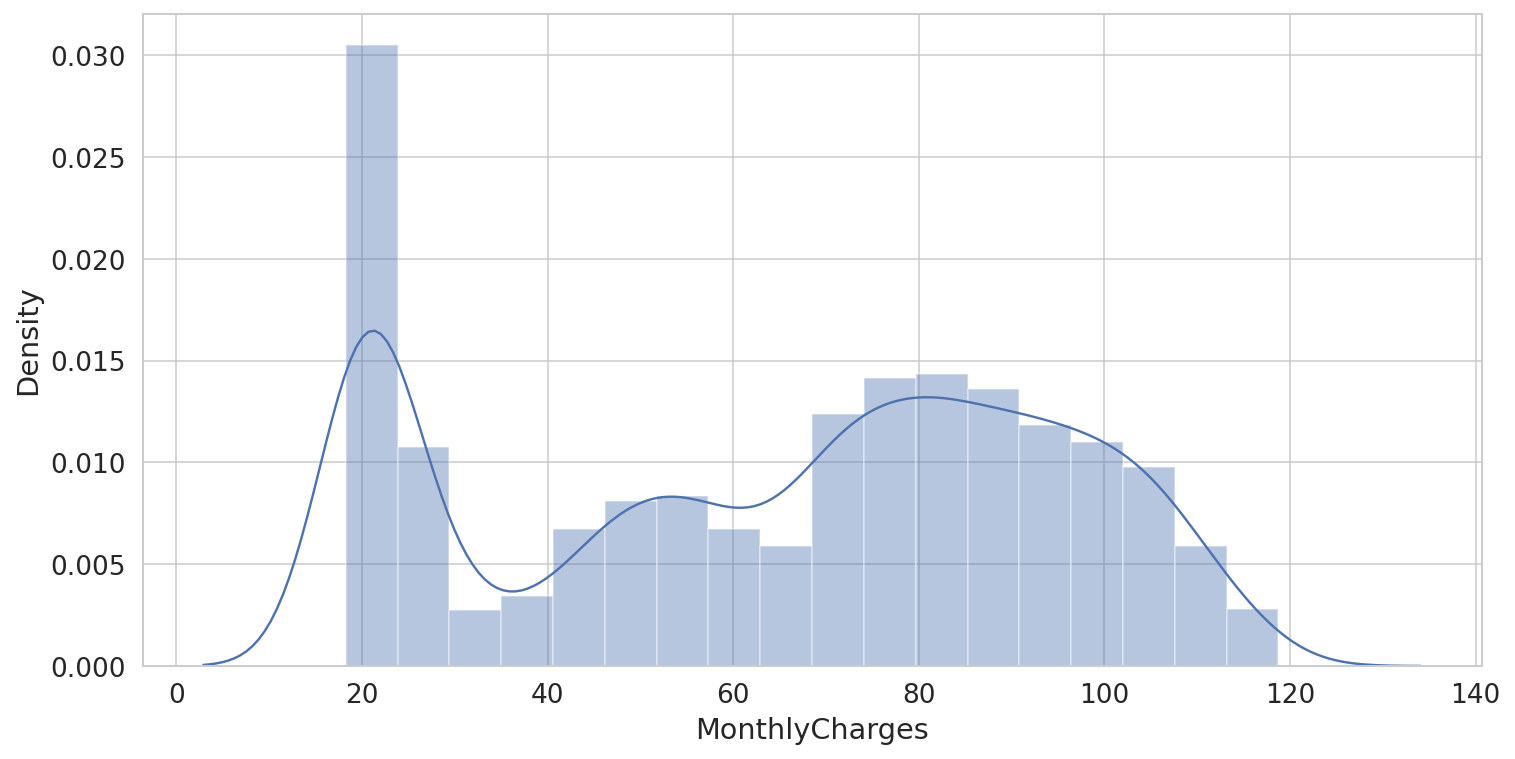

In [45]:
sns.distplot(df_merged_new['MonthlyCharges'])

Вследствие чего возникли надежды на возможное улучшение качества прогнозирования путем перевода количественной переменной MonthlyCharges в категориальную с помощью кластеризации.

In [46]:
# Делаем копию датасета

df_merged_cluster = df_merged_new.copy()

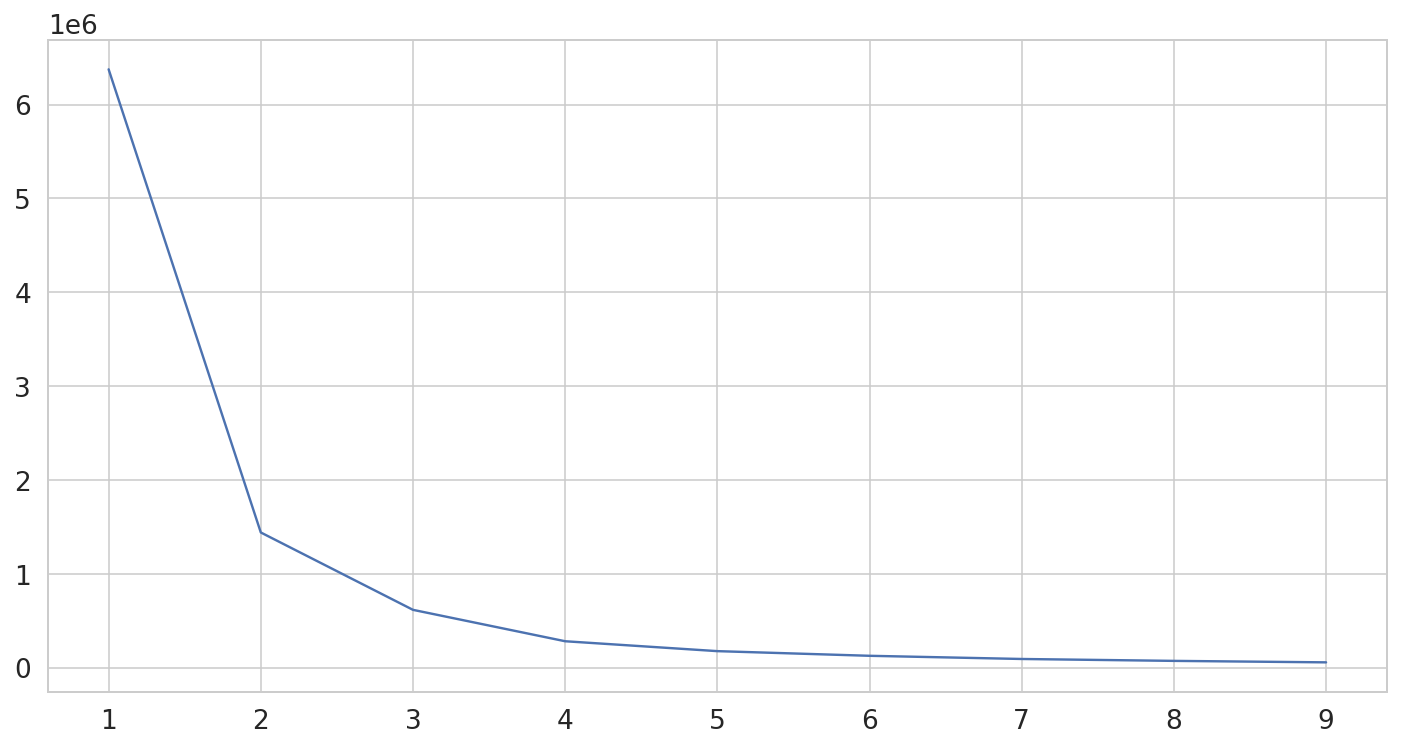

In [47]:
sns.lineplot(x=range(1, 10), 
             y=(KMeans(k, random_state=42).fit(df_merged_cluster['MonthlyCharges'].values.reshape(-1, 1)).inertia_
                for k in range(1, 10)))

Оценка с помощью "метода локтя" подтверждает догадку о трех кластерах. Остается добавить новый признак, удалив при этом изначальный столбец, и протестировать модели на новых данных.

In [48]:
df_merged_cluster = df_merged_cluster.assign(clusters=KMeans(3, random_state=42).
                                             fit_predict(df_merged_cluster['MonthlyCharges'].
                                                         values.reshape(-1, 1))).drop('MonthlyCharges', axis=1)

In [49]:
# На всякий случай проверим значения в столбце

df_merged_cluster['clusters'].unique()

array([2, 0, 1], dtype=int32)

In [50]:
X = df_merged_cluster.drop(['Churn'], axis=1)
y = df_merged_cluster['Churn']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 21), (1761, 21), (5282,), (1761,))

In [51]:
X_train.head(3)

,PaperlessBilling,lifetime,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,gender_Male,clusters
6607,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,2
2598,0,215,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2345,0,123,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


#### LogisticRegression

In [52]:
log_reg = model_grid(logreg_params)
model_test(log_reg)

auc_roc: 0.8315645569455347
accuracy: 0.7495741056218058


#### XGBClassifier

In [53]:
xgb = model_grid(xgb_params)
model_test(xgb)

auc_roc: 0.9158404958327769
accuracy: 0.848381601362862


#### LGBMClassifier

In [54]:
lgdb = model_grid(lgbm_params)
model_test(lgdb)

auc_roc: 0.9126479046635769
accuracy: 0.8517887563884157


#### CatBoostClassifier

In [55]:
cat_clf = model_grid(cat_params)
model_test(cat_clf)

auc_roc: 0.9320908744491742
accuracy: 0.8705281090289608


## 2.4 Выводы <a id='8-bullet'></a>

Намеченный план работы был выполнен в полном объеме: данные были предобработаны, изучены, после чего был проведен ряд тестов и выбрана лучшая модель - CatBoostClassifier ( AUC ROC - 0.9320). Алгоритм LogisticRegression стабильно демонстрировал самые слабые результаты.

У нас было три основных этапа тестов:
- "Голые" фичи сразу же после этапа предобработки, где лучше всего себя проявил CatBoostClassifier ( AUC ROC - 0.9191)
- Была удалена зависимая переменная 'TotalCharges', что положительно сказалось на качестве предсказаний деревянных моделей, особенно CatBoostClassifier (0.9255)

- Был применен алгоритм KMeans для трансформации количественной переменной 'MonthlyCharges' в категориальную. Данный шаг хорошо сказался на метрике: XGBoostClassifier (0.9158), LGBMClassifier (0.9126) и CatBoostClassifier (0.9320) - явный лидер и наш итоговый выбор.
